In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV
import warnings
from sklearn.exceptions import ConvergenceWarning



# Arguments

In [63]:
args = {'noise':0.01,
        'percent training data':0.7,
        'spec scale':10**12,
        }

all_layer_args = {
        'learning rate':0.01,
        'training epochs':5000,

        'loss fn':nn.L1Loss(),
        'optimizer':torch.optim.Rprop
        }

one_layer_args = {
        'learning rate':0.01,
        'training epochs':1000,

        'feature threshold':0.2,
        'dropout':0.5,
        'hidden layers':2,

        'loss fn':nn.L1Loss(),
        'optimizer':torch.optim.Rprop
        }

now = datetime.now()

# Data Prep

In [64]:
# fn to convert dataframes to tensors
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [65]:
all_layer_df = pd.read_excel('data_3nm.xlsx')
one_layer_df = pd.read_excel('data_3nm.xlsx')

all_spec = all_layer_df.iloc[:,11:]
all_temp = all_layer_df.iloc[:,:11]

one_spec = one_layer_df.iloc[:,11:]
one_temp = one_layer_df.iloc[:,:11]

In [66]:
all_spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,3.105584e-14,3.052205e-14,4.107059e-14,4.675147e-14,3.859431e-14,2.935851e-14,3.151355e-14,4.473981e-14,4.390755e-14,3.170344e-14,...,2.255215e-12,2.250856e-12,2.246458e-12,2.242043e-12,2.237622e-12,2.233144e-12,2.228542e-12,2.223762e-12,2.218939e-12,2.214334e-12
1,2.303472e-14,2.243980e-14,2.986917e-14,3.394207e-14,2.823448e-14,2.151428e-14,2.288213e-14,3.211078e-14,3.169674e-14,2.301430e-14,...,1.636173e-12,1.633204e-12,1.630206e-12,1.627196e-12,1.624179e-12,1.621120e-12,1.617971e-12,1.614691e-12,1.611379e-12,1.608225e-12
2,3.321009e-14,3.183994e-14,4.156518e-14,4.707322e-14,3.965683e-14,3.022635e-14,3.161482e-14,4.346603e-14,4.329419e-14,3.168369e-14,...,4.265080e-12,4.255842e-12,4.246534e-12,4.237201e-12,4.227860e-12,4.218417e-12,4.208743e-12,4.198740e-12,4.188660e-12,4.178998e-12
3,1.357453e-14,1.306165e-14,1.711864e-14,1.942411e-14,1.632974e-14,1.246013e-14,1.307745e-14,1.806431e-14,1.797263e-14,1.314374e-14,...,2.689740e-12,2.684366e-12,2.678947e-12,2.673510e-12,2.668065e-12,2.662553e-12,2.656894e-12,2.651024e-12,2.645104e-12,2.639444e-12
4,2.619885e-14,2.531656e-14,3.336945e-14,3.787416e-14,3.170747e-14,2.416178e-14,2.548633e-14,3.541894e-14,3.511435e-14,2.559810e-14,...,3.023923e-12,3.017753e-12,3.011531e-12,3.005289e-12,2.999040e-12,2.992716e-12,2.986228e-12,2.979503e-12,2.972721e-12,2.966234e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,2.956149e-14,2.846418e-14,3.735680e-14,4.237698e-14,3.557164e-14,2.710359e-14,2.848041e-14,3.940371e-14,3.914222e-14,2.857967e-14,...,4.376826e-12,4.367304e-12,4.357712e-12,4.348093e-12,4.338467e-12,4.328736e-12,4.318769e-12,4.308464e-12,4.298080e-12,4.288126e-12
2196,3.749401e-14,3.641635e-14,4.832023e-14,5.488017e-14,4.572003e-14,3.481850e-14,3.692342e-14,5.165697e-14,5.104080e-14,3.708188e-14,...,3.737057e-12,3.729141e-12,3.721165e-12,3.713165e-12,3.705158e-12,3.697059e-12,3.688758e-12,3.680167e-12,3.671508e-12,3.663214e-12
2197,2.472354e-14,2.407549e-14,3.204759e-14,3.642555e-14,3.030117e-14,2.307305e-14,2.453848e-14,3.444697e-14,3.399959e-14,2.467478e-14,...,3.172314e-12,3.165785e-12,3.159202e-12,3.152599e-12,3.145989e-12,3.139300e-12,3.132439e-12,3.125330e-12,3.118162e-12,3.111303e-12
2198,3.013358e-14,2.888866e-14,3.770118e-14,4.269718e-14,3.597842e-14,2.743253e-14,2.868471e-14,3.942280e-14,3.927214e-14,2.875220e-14,...,3.383006e-12,3.375964e-12,3.368865e-12,3.361745e-12,3.354617e-12,3.347406e-12,3.340011e-12,3.332353e-12,3.324633e-12,3.317242e-12


In [67]:
one_spec

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,3.105584e-14,3.052205e-14,4.107059e-14,4.675147e-14,3.859431e-14,2.935851e-14,3.151355e-14,4.473981e-14,4.390755e-14,3.170344e-14,...,2.255215e-12,2.250856e-12,2.246458e-12,2.242043e-12,2.237622e-12,2.233144e-12,2.228542e-12,2.223762e-12,2.218939e-12,2.214334e-12
1,2.303472e-14,2.243980e-14,2.986917e-14,3.394207e-14,2.823448e-14,2.151428e-14,2.288213e-14,3.211078e-14,3.169674e-14,2.301430e-14,...,1.636173e-12,1.633204e-12,1.630206e-12,1.627196e-12,1.624179e-12,1.621120e-12,1.617971e-12,1.614691e-12,1.611379e-12,1.608225e-12
2,3.321009e-14,3.183994e-14,4.156518e-14,4.707322e-14,3.965683e-14,3.022635e-14,3.161482e-14,4.346603e-14,4.329419e-14,3.168369e-14,...,4.265080e-12,4.255842e-12,4.246534e-12,4.237201e-12,4.227860e-12,4.218417e-12,4.208743e-12,4.198740e-12,4.188660e-12,4.178998e-12
3,1.357453e-14,1.306165e-14,1.711864e-14,1.942411e-14,1.632974e-14,1.246013e-14,1.307745e-14,1.806431e-14,1.797263e-14,1.314374e-14,...,2.689740e-12,2.684366e-12,2.678947e-12,2.673510e-12,2.668065e-12,2.662553e-12,2.656894e-12,2.651024e-12,2.645104e-12,2.639444e-12
4,2.619885e-14,2.531656e-14,3.336945e-14,3.787416e-14,3.170747e-14,2.416178e-14,2.548633e-14,3.541894e-14,3.511435e-14,2.559810e-14,...,3.023923e-12,3.017753e-12,3.011531e-12,3.005289e-12,2.999040e-12,2.992716e-12,2.986228e-12,2.979503e-12,2.972721e-12,2.966234e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,2.956149e-14,2.846418e-14,3.735680e-14,4.237698e-14,3.557164e-14,2.710359e-14,2.848041e-14,3.940371e-14,3.914222e-14,2.857967e-14,...,4.376826e-12,4.367304e-12,4.357712e-12,4.348093e-12,4.338467e-12,4.328736e-12,4.318769e-12,4.308464e-12,4.298080e-12,4.288126e-12
2196,3.749401e-14,3.641635e-14,4.832023e-14,5.488017e-14,4.572003e-14,3.481850e-14,3.692342e-14,5.165697e-14,5.104080e-14,3.708188e-14,...,3.737057e-12,3.729141e-12,3.721165e-12,3.713165e-12,3.705158e-12,3.697059e-12,3.688758e-12,3.680167e-12,3.671508e-12,3.663214e-12
2197,2.472354e-14,2.407549e-14,3.204759e-14,3.642555e-14,3.030117e-14,2.307305e-14,2.453848e-14,3.444697e-14,3.399959e-14,2.467478e-14,...,3.172314e-12,3.165785e-12,3.159202e-12,3.152599e-12,3.145989e-12,3.139300e-12,3.132439e-12,3.125330e-12,3.118162e-12,3.111303e-12
2198,3.013358e-14,2.888866e-14,3.770118e-14,4.269718e-14,3.597842e-14,2.743253e-14,2.868471e-14,3.942280e-14,3.927214e-14,2.875220e-14,...,3.383006e-12,3.375964e-12,3.368865e-12,3.361745e-12,3.354617e-12,3.347406e-12,3.340011e-12,3.332353e-12,3.324633e-12,3.317242e-12


In [68]:
# scale spectrum data by 10^12
all_spec = all_spec.apply(lambda x: x*args['spec scale'])
one_spec = one_spec.apply(lambda x: x*args['spec scale'])

In [69]:
# add noise
all_noise = np.random.normal(loc=0, scale=args['noise'], size=all_spec.shape)
one_noise = np.random.normal(loc=0, scale=args['noise'], size=one_spec.shape)

all_spec_noisy = all_spec + all_noise
one_spec_noisy = one_spec + one_noise

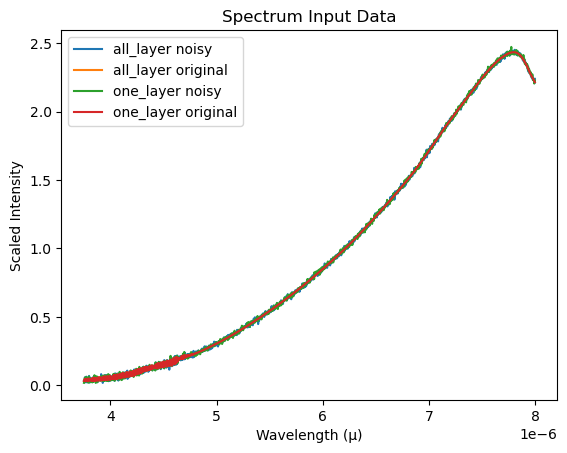

In [70]:
plt.title('Spectrum Input Data')
plt.plot(all_spec_noisy.iloc[0], label='all_layer noisy')
plt.plot(all_spec.iloc[0], label='all_layer original')
plt.plot(one_spec_noisy.iloc[0], label='one_layer noisy')
plt.plot(one_spec.iloc[0], label='one_layer original')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Scaled Intensity")
plt.legend()
plt.show()

In [71]:
# Normalize clean and noisy spectrum data
scaler = preprocessing.StandardScaler()

# all_layer
scaler.fit(all_spec)
all_spec_scaled = scaler.transform(all_spec)

scaler.fit(all_spec_noisy)
all_spec_noisy_scaled = scaler.transform(all_spec_noisy)

all_spec_scaled_df = pd.DataFrame(all_spec_scaled, columns=all_spec.columns)
all_spec_noisy_scaled_df = pd.DataFrame(all_spec_noisy_scaled, columns = all_spec.columns)

# one_layer
scaler.fit(one_spec)
one_spec_scaled = scaler.transform(one_spec)

scaler.fit(one_spec_noisy)
one_spec_noisy_scaled = scaler.transform(one_spec_noisy)

one_spec_scaled_df = pd.DataFrame(one_spec_scaled, columns=one_spec.columns)
one_spec_noisy_scaled_df = pd.DataFrame(one_spec_noisy_scaled, columns = one_spec.columns)

/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(
/Users/aidenkarpf/anaconda3/lib/python3.10/sklea

In [72]:
one_spec_noisy_scaled_df

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,-0.618626,0.377151,0.347896,1.045871,0.600740,1.168960,-0.033366,0.146937,1.571880,1.023094,...,-0.311827,-0.296219,-0.305094,-0.322157,-0.312716,-0.308619,-0.312628,-0.327910,-0.305841,-0.302681
1,-0.822391,0.895955,-0.520991,-0.141901,0.756774,0.013680,0.362955,0.567093,-0.165414,-0.384791,...,-0.816379,-0.796950,-0.792842,-0.803987,-0.801434,-0.795099,-0.799638,-0.811908,-0.806400,-0.804796
2,-0.572534,1.966884,1.296395,0.718955,-0.333078,0.907366,1.059926,0.863215,0.664954,-0.143123,...,1.276286,1.287815,1.275880,1.286456,1.270279,1.290692,1.275042,1.262656,1.274124,1.275294
3,-0.272681,-1.258409,-0.986350,-0.613065,-1.389645,-1.909860,-0.470815,-0.746531,-0.829891,-0.848321,...,0.036634,0.034231,0.040284,0.029728,0.042276,0.021256,0.033363,0.040690,0.031792,0.036382
4,1.191834,-0.684905,0.207975,0.040628,0.365178,0.084484,-0.565575,-0.309779,-0.136772,-1.042842,...,0.288413,0.295992,0.299374,0.296723,0.298669,0.289187,0.281181,0.295830,0.291801,0.296636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-0.588281,0.690139,0.472105,0.059695,0.076213,0.091113,-0.306991,-0.077661,1.019829,1.015274,...,1.373940,1.363027,1.369672,1.368141,1.361296,1.370870,1.367583,1.367723,1.370677,1.379044
2196,0.721955,1.190932,0.145278,0.212695,0.643240,1.421026,-0.401573,0.823433,0.745523,0.336305,...,0.863704,0.844083,0.854764,0.875701,0.844162,0.857604,0.864508,0.856058,0.852936,0.862776
2197,0.062762,0.691682,0.562603,-0.091475,-0.099844,-0.515497,0.294770,-0.640724,-1.003594,-0.304612,...,0.424450,0.413818,0.419550,0.400023,0.406041,0.406069,0.421649,0.414111,0.424248,0.425111
2198,0.374691,-1.210950,1.357093,0.369941,0.590050,0.484993,0.542632,0.523118,-0.154439,-0.426764,...,0.582769,0.568485,0.582322,0.578294,0.567518,0.579382,0.593553,0.571841,0.583895,0.570540


In [73]:
all_spec_noisy_scaled_df

,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.408039,0.500701,0.431244,1.100751,1.376249,-0.178013,-0.178589,1.544549,0.927441,1.191208,...,-0.309269,-0.304074,-0.319888,-0.322584,-0.312471,-0.315865,-0.314663,-0.310855,-0.322410,-0.292621
1,-0.006209,-0.350462,-1.048468,0.244177,-0.182969,0.336396,0.387769,0.975289,-0.239561,-1.095066,...,-0.789012,-0.794220,-0.802265,-0.801188,-0.815225,-0.799463,-0.810110,-0.800738,-0.804625,-0.798134
2,0.823340,0.734560,1.234567,0.032531,0.824069,0.328848,0.705174,0.618597,0.754845,1.166096,...,1.272489,1.282399,1.274995,1.258866,1.279218,1.286011,1.289760,1.280751,1.288185,1.268784
3,-2.268664,-1.360840,-0.379341,-2.091196,-0.514405,-1.863422,-1.158616,-1.234194,-0.312870,-0.212107,...,0.029976,0.025223,0.031769,0.029699,0.036015,0.022935,0.022427,0.032008,0.031554,0.027894
4,-1.017983,0.825096,-0.185964,0.088058,-0.317554,-0.248728,-0.110600,0.731553,-0.198393,0.355807,...,0.297400,0.279640,0.284100,0.294711,0.299304,0.284408,0.294984,0.301805,0.301252,0.299655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0.548140,0.469429,0.503408,1.027813,0.890916,0.888522,0.548296,1.582216,-0.121738,1.098521,...,1.349632,1.354080,1.359153,1.366573,1.373827,1.365147,1.361431,1.361280,1.366870,1.379209
2196,2.226698,0.909384,0.615471,1.577477,0.596560,1.056588,1.580708,0.808795,2.327922,1.729084,...,0.854150,0.856576,0.861254,0.860108,0.861780,0.865999,0.855641,0.864920,0.859745,0.860819
2197,0.836015,-1.370386,-0.548259,-0.353803,-1.157626,0.103125,-1.337794,0.163081,0.332831,-1.088696,...,0.413989,0.401168,0.408812,0.416532,0.416639,0.418772,0.403501,0.397985,0.403461,0.412592
2198,1.471818,-0.143475,0.153393,0.286524,0.910495,0.062981,0.629300,-0.089385,0.254719,0.194919,...,0.560026,0.589208,0.569041,0.581537,0.577994,0.570882,0.586218,0.569533,0.574278,0.581235


In [74]:
all_temp

,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,layer 11
0,364.787366,317.684838,313.810126,303.307879,314.323118,317.828320,318.557698,308.808121,309.953331,296.299100,318.002181
1,342.552920,335.048875,325.169322,323.807685,312.667938,307.509532,318.808960,312.412740,305.472749,315.420270,301.044787
2,314.150653,325.319947,330.529579,337.855852,336.525836,349.311552,336.370506,342.758437,344.195955,333.964029,357.969610
3,302.513193,306.523372,315.214925,315.629483,313.136991,312.378427,319.314782,302.018575,306.730069,310.949569,328.143455
4,332.142887,315.836569,320.947657,325.884656,338.307720,339.673089,334.705064,325.483513,321.166972,307.175291,335.245173
...,...,...,...,...,...,...,...,...,...,...,...
2195,327.359960,331.887028,335.439802,327.858751,329.905634,332.466652,323.482462,319.992829,334.062241,326.323524,359.801763
2196,354.311013,341.927755,337.451821,323.967416,330.097748,313.792185,317.839648,318.627400,331.026918,344.846164,348.886578
2197,345.013997,323.826484,315.340107,306.337376,314.184375,306.270021,304.561202,313.513715,321.161351,326.559357,338.238519
2198,309.706144,313.843492,332.026895,338.820759,345.317550,352.584174,339.603698,337.521742,337.254720,328.544064,342.340353


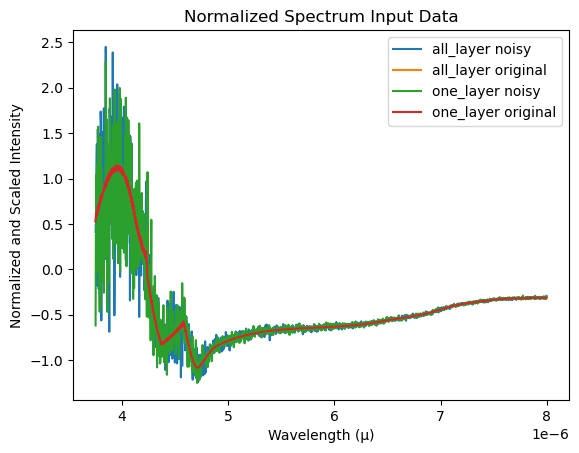

In [75]:
plt.title('Normalized Spectrum Input Data')
plt.plot(all_spec_noisy_scaled_df.iloc[0], label='all_layer noisy')
plt.plot(all_spec_scaled_df.iloc[0], label='all_layer original')
plt.plot(one_spec_noisy_scaled_df.iloc[0], label='one_layer noisy')
plt.plot(one_spec_scaled_df.iloc[0], label='one_layer original')
plt.xlabel("Wavelength (µ)")
plt.ylabel("Normalized and Scaled Intensity")
plt.legend()
plt.show()

In [76]:
all_spec_train_df, all_spec_test_df, all_temp_train_df, all_temp_test_df = train_test_split(all_spec_noisy_scaled_df, all_temp, train_size=args['percent training data'], random_state=101)

all_spec_train = df_to_tensor(all_spec_train_df)
all_spec_test = df_to_tensor(all_spec_test_df)
all_temp_train = df_to_tensor(all_temp_train_df)
all_temp_test = df_to_tensor(all_temp_test_df)

In [77]:
one_spec_train_df, one_spec_test_df, one_temp_train_df, one_temp_test_df = train_test_split(one_spec_noisy_scaled_df, one_temp, train_size=args['percent training data'], random_state=101)
one_spec_train = df_to_tensor(one_spec_train_df)
one_spec_test = df_to_tensor(one_spec_test_df)
one_temp_train = df_to_tensor(one_temp_train_df)
one_temp_test = df_to_tensor(one_temp_test_df)

In [78]:
one_temp_train

tensor([[279.2097, 291.1372, 304.6712,  ..., 309.0874, 307.9146, 287.3898],
        [284.7944, 309.4465, 334.0897,  ..., 303.7473, 311.2545, 366.0722],
        [303.5786, 296.0121, 320.1395,  ..., 300.9098, 290.0527, 305.2413],
        ...,
        [293.5930, 300.5022, 312.8386,  ..., 306.9922, 292.7501, 293.1349],
        [337.4347, 345.6631, 344.0024,  ..., 324.8639, 323.7931, 333.0087],
        [293.4902, 286.4892, 303.6414,  ..., 345.2938, 341.2333, 361.8345]])

In [79]:
one_temp_train_df

,layer 1,layer 2,layer 3,layer 4,layer 5,layer 6,layer 7,layer 8,layer 9,layer 10,layer 11
805,279.209743,291.137221,304.671212,321.530815,329.446994,327.029105,313.960558,324.310987,309.087402,307.914547,287.389829
1798,284.794420,309.446547,334.089700,350.676110,338.351686,338.961686,320.533221,304.078196,303.747342,311.254536,366.072198
193,303.578596,296.012106,320.139477,331.612634,343.149874,341.599287,327.050020,312.050438,300.909822,290.052707,305.241303
162,281.108362,326.802138,327.622403,330.956774,328.315642,325.316098,330.881045,323.297827,335.718231,335.832163,359.882238
1211,305.883115,309.732322,311.271401,307.804161,319.833550,314.919764,314.269008,322.242702,336.473803,341.159050,359.702423
...,...,...,...,...,...,...,...,...,...,...,...
599,289.901273,303.797299,314.640206,322.380250,322.906980,334.804410,332.806097,340.696287,332.441968,326.199472,287.329896
1599,332.949636,338.770840,326.556094,318.249358,324.882489,324.553302,316.494734,332.146005,345.986547,338.350044,360.618668
1361,293.593005,300.502237,312.838567,309.084343,316.565921,318.843820,304.805597,303.329649,306.992251,292.750057,293.134899
1547,337.434701,345.663135,344.002401,350.968885,344.162538,341.646016,347.224707,332.715609,324.863918,323.793078,333.008666


# Feature Selection

In [80]:
# create list of layer dictionaries for one_layer model
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})
    
print(layers)

[{'layer': 1, 'col': 'layer 1'}, {'layer': 2, 'col': 'layer 2'}, {'layer': 3, 'col': 'layer 3'}, {'layer': 4, 'col': 'layer 4'}, {'layer': 5, 'col': 'layer 5'}, {'layer': 6, 'col': 'layer 6'}, {'layer': 7, 'col': 'layer 7'}, {'layer': 8, 'col': 'layer 8'}, {'layer': 9, 'col': 'layer 9'}, {'layer': 10, 'col': 'layer 10'}, {'layer': 11, 'col': 'layer 11'}]


In [81]:
# feature selection
for layer in layers:
    targets = one_temp[(layer['col'])]

    lasso = LassoCV(max_iter=1000)
    lasso.fit(one_spec_noisy_scaled_df, targets)
    selected_features = one_spec.columns[abs(lasso.coef_) >= one_layer_args['feature threshold']]

    layer['features'] = selected_features

    # Ignore convergence warnings
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    print(f'Features for {layer["col"].capitalize()} ({len(selected_features)}):\n {selected_features}\n')

/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 1 (114):
 Index([3.753e-06, 3.771e-06, 3.792e-06,  3.81e-06, 3.825e-06, 3.849e-06,
       3.855e-06, 3.858e-06, 3.879e-06, 3.885e-06,
       ...
       4.674e-06, 4.686e-06, 4.689e-06, 4.707e-06, 4.854e-06,  4.92e-06,
       4.935e-06, 4.989e-06, 5.052e-06, 5.196e-06],
      dtype='object', length=114)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 2 (304):
 Index([3.753e-06, 3.756e-06, 3.759e-06, 3.765e-06, 3.768e-06,  3.78e-06,
       3.786e-06, 3.789e-06, 3.795e-06, 3.804e-06,
       ...
       7.206e-06, 7.269e-06, 7.284e-06, 7.314e-06, 7.317e-06, 7.371e-06,
       7.443e-06, 7.452e-06, 7.467e-06, 7.518e-06],
      dtype='object', length=304)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 3 (342):
 Index([3.756e-06, 3.771e-06, 3.789e-06, 3.801e-06, 3.804e-06, 3.828e-06,
       3.831e-06, 3.834e-06, 3.843e-06, 3.852e-06,
       ...
       7.368e-06, 7.392e-06, 7.407e-06, 7.416e-06, 7.419e-06, 7.443e-06,
       7.458e-06, 7.464e-06, 7.506e-06, 7.572e-06],
      dtype='object', length=342)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 4 (340):
 Index([ 3.75e-06, 3.756e-06, 3.759e-06, 3.765e-06, 3.786e-06, 3.789e-06,
       3.792e-06, 3.798e-06, 3.801e-06, 3.804e-06,
       ...
       7.353e-06, 7.395e-06, 7.413e-06, 7.431e-06, 7.464e-06, 7.491e-06,
       7.524e-06,  7.56e-06, 7.587e-06, 7.641e-06],
      dtype='object', length=340)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 5 (108):
 Index([3.756e-06, 3.795e-06, 3.798e-06, 3.807e-06, 3.849e-06, 3.852e-06,
       3.876e-06, 3.882e-06, 3.894e-06, 3.903e-06,
       ...
       7.347e-06, 7.371e-06, 7.422e-06, 7.452e-06, 7.467e-06, 7.482e-06,
       7.494e-06, 7.518e-06, 7.545e-06, 7.569e-06],
      dtype='object', length=108)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 6 (311):
 Index([3.756e-06, 3.765e-06, 3.774e-06, 3.798e-06, 3.804e-06, 3.816e-06,
       3.831e-06, 3.876e-06, 3.879e-06, 3.882e-06,
       ...
        7.44e-06, 7.452e-06, 7.455e-06, 7.467e-06, 7.494e-06, 7.503e-06,
       7.512e-06, 7.518e-06, 7.545e-06,  7.59e-06],
      dtype='object', length=311)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 7 (270):
 Index([ 3.75e-06, 3.759e-06,  3.78e-06, 3.798e-06, 3.807e-06,  3.81e-06,
       3.819e-06, 3.825e-06, 3.834e-06,  3.87e-06,
       ...
       7.416e-06, 7.434e-06, 7.443e-06, 7.467e-06,  7.47e-06, 7.482e-06,
       7.491e-06, 7.512e-06, 7.524e-06, 7.539e-06],
      dtype='object', length=270)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 8 (216):
 Index([3.801e-06, 3.804e-06, 3.828e-06, 3.831e-06, 3.852e-06, 3.858e-06,
       3.861e-06, 3.867e-06, 3.879e-06, 3.888e-06,
       ...
       6.573e-06, 6.591e-06, 6.669e-06, 6.726e-06, 6.867e-06, 6.873e-06,
       6.888e-06, 7.458e-06, 7.506e-06, 7.572e-06],
      dtype='object', length=216)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 9 (254):
 Index([3.759e-06, 3.786e-06, 3.801e-06, 3.804e-06, 3.813e-06, 3.816e-06,
       3.825e-06, 3.828e-06, 3.831e-06,  3.87e-06,
       ...
       7.056e-06, 7.062e-06, 7.077e-06, 7.104e-06, 7.215e-06, 7.869e-06,
       7.923e-06, 7.956e-06, 7.977e-06, 7.995e-06],
      dtype='object', length=254)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 10 (418):
 Index([3.753e-06, 3.756e-06, 3.774e-06, 3.786e-06, 3.798e-06, 3.801e-06,
        3.81e-06, 3.825e-06, 3.837e-06, 3.846e-06,
       ...
       7.902e-06, 7.905e-06, 7.914e-06,  7.92e-06, 7.929e-06, 7.938e-06,
       7.941e-06, 7.968e-06, 7.983e-06, 7.986e-06],
      dtype='object', length=418)



/Users/aidenkarpf/anaconda3/lib/python3.10/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


Features for Layer 11 (191):
 Index([3.903e-06, 3.978e-06, 4.026e-06, 4.131e-06, 4.158e-06, 4.314e-06,
       4.371e-06, 4.374e-06, 4.377e-06,  4.38e-06,
       ...
       7.929e-06, 7.932e-06, 7.935e-06, 7.938e-06, 7.953e-06, 7.968e-06,
       7.977e-06, 7.986e-06, 7.992e-06, 7.995e-06],
      dtype='object', length=191)



In [99]:
for layer in layers:
    layer['temp_train'] = torch.tensor(one_temp_train_df[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['temp_test'] = torch.tensor(one_temp_test_df[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['spec_train'] = torch.tensor(one_spec_train_df[layer['features']].values, dtype=torch.float32)
    layer['spec_test'] = torch.tensor(one_spec_test_df[layer['features']].values, dtype=torch.float32)

# Model Design

In [83]:
class All_Layer_Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(All_Layer_Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 30)
        # self.lin2 = nn.Linear(30, 45)
        # self.lin3 = nn.Linear(45, 60)
        # self.lin4 = nn.Linear(60, 60)
        # self.lin5 = nn.Linear(60, 60)
        self.lin_fin = nn.Linear(30, output_size)

    def forward(self, spec):
        x = F.leaky_relu(self.lin1(spec))
        # x = F.leaky_relu(self.lin2(x))
        # x = F.leaky_relu(self.lin3(x))
        # x = F.leaky_relu(self.lin4(x))
        # x = F.leaky_relu(self.lin5(x))
        pred_temp = self.lin_fin(x)
        return pred_temp

In [84]:
class One_Layer_Net(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(One_Layer_Net, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)
        self.dropout = nn.Dropout(one_layer_args['dropout'])

    def forward(self, x):

        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.dropout(x)
        x = self.lin_fin(x)
        return x

In [85]:
# define all_layer model
_, all_layer_output_size = all_temp.shape
_, all_layer_input_size = all_spec_noisy_scaled_df.shape
all_layer_model = All_Layer_Net(all_layer_input_size, all_layer_output_size)

# one_layer models are defined in training funciton

# Training Loops

In [86]:
# all_layer training

def train_all_layer(all_layer_model, all_spec_train):
    print('\nTRAINING ALL_LAYER MODEL')


    loss_list = []
    loss_sum = 0

    num_epochs = all_layer_args['training epochs']
    criterion = all_layer_args['loss fn']
    optimizer = all_layer_args['optimizer'](all_layer_model.parameters(), lr=all_layer_args['learning rate'])

    for epoch in range(num_epochs):
        pred_temp = all_layer_model(all_spec_train)

        # calculate loss
        loss = criterion(all_temp_train, pred_temp)

        # empty gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update
        optimizer.step()

        # find average loss after first 100 epochs
        if epoch > 100:
            loss_sum += loss.item()

        loss_list.append(loss.item())

        # print loss every 10% of epochs
        if (epoch + 1) % (num_epochs / 10) == 0:
            print(f'epoch: {epoch + 1}, loss = {loss}')

    print(f'epoch: {epoch + 1}, loss = {loss}')

    avg_training_loss = loss_sum / (num_epochs - 100)
    print(f'\naverage training loss (across all layers): {avg_training_loss}')
    
    return loss_list

In [87]:
# one_layer training
def train_one_layer(One_Layer_Net):
    print('\nTRAINING ONE LAYER MODEL')
    criterion = one_layer_args['loss fn']

    for layer in layers:
        print(layer['col'])
        input = layer['spec_train']
        target = layer['temp_train']

        # instantiate model
        model = One_Layer_Net(input.size()[1], target.size()[1], one_layer_args['hidden layers'])

        best_loss = np.inf
        best_epoch = 0
        train_losses = []

        optimizer = torch.optim.Rprop(model.parameters(), lr=one_layer_args['learning rate'])

        print(f'hidden layer sizes: {model.hidden_sizes}')

        for epoch in range(one_layer_args['training epochs']):
            # forward pass
            outputs = model(input)

            # get loss
            loss = criterion(outputs, target)

            # update and backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            
            if loss.item() < best_loss:
                best_loss = loss.item()
                best_epoch = epoch+1

            if (epoch+1) % int(one_layer_args['training epochs']/10) == 0:
                print(f'epoch: {epoch+1}, loss = {loss}')

        # store model and losses
        layer['model'] = model
        layer['train losses'] = train_losses

        print(f'best loss: {best_loss} in epoch {best_epoch}\n')

    return layers, train_losses    

In [88]:
all_loss_list = train_all_layer(all_layer_model, all_spec_train)


TRAINING ALL_LAYER MODEL
epoch: 500, loss = 4.283517360687256
epoch: 1000, loss = 3.8611860275268555
epoch: 1500, loss = 3.7832210063934326
epoch: 2000, loss = 3.772096633911133
epoch: 2500, loss = 3.768347978591919
epoch: 3000, loss = 3.7662363052368164
epoch: 3500, loss = 3.7647809982299805
epoch: 4000, loss = 3.7634694576263428
epoch: 4500, loss = 3.7625296115875244
epoch: 5000, loss = 3.761894702911377
epoch: 5000, loss = 3.761894702911377

average training loss (across all layers): 3.9031172542669337


In [89]:
layers, one_loss_list = train_one_layer(One_Layer_Net)


TRAINING ONE LAYER MODEL
layer 1
hidden layer sizes: [114, 76, 38]
epoch: 100, loss = 14.835187911987305
epoch: 200, loss = 8.55250358581543
epoch: 300, loss = 7.954189300537109
epoch: 400, loss = 7.621126651763916
epoch: 500, loss = 7.691842079162598
epoch: 600, loss = 7.593838691711426
epoch: 700, loss = 7.642978191375732
epoch: 800, loss = 7.399608135223389
epoch: 900, loss = 7.603790283203125
epoch: 1000, loss = 7.3785719871521
best loss: 7.278633117675781 in epoch 833

layer 2
hidden layer sizes: [304, 202, 101]
epoch: 100, loss = 17.474149703979492
epoch: 200, loss = 9.84217643737793
epoch: 300, loss = 9.131332397460938
epoch: 400, loss = 8.570472717285156
epoch: 500, loss = 8.307487487792969
epoch: 600, loss = 8.30184268951416
epoch: 700, loss = 7.997734069824219
epoch: 800, loss = 7.99482536315918
epoch: 900, loss = 8.049578666687012
epoch: 1000, loss = 8.009566307067871
best loss: 7.713499546051025 in epoch 956

layer 3
hidden layer sizes: [342, 228, 114]
epoch: 100, loss = 2

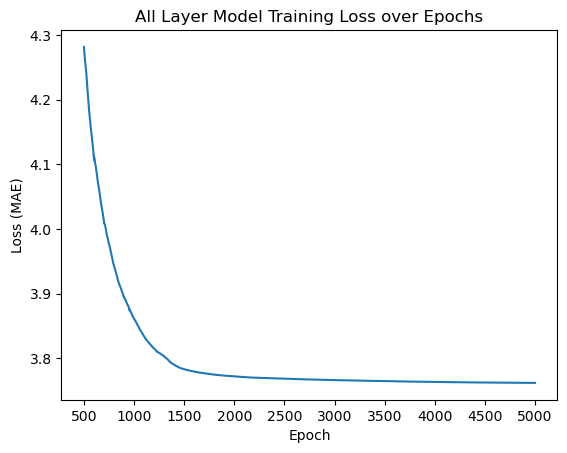

In [90]:
# plot all_layer loss over epochs

# add 500 to x-axis values
x_values = range(500, all_layer_args['training epochs'])
plt.plot(x_values, all_loss_list[500:])
plt.xticks(range(500, all_layer_args['training epochs'] + 500, all_layer_args['training epochs'] // 10))

plt.title("All Layer Model Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.show()

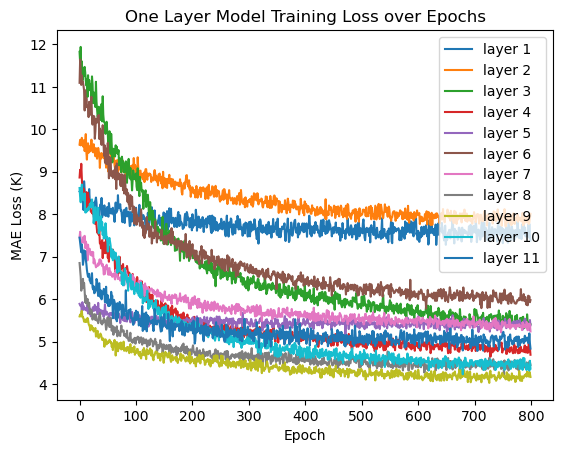

In [91]:
for layer in layers:
    plt.plot(layer['train losses'][200:], label=layer['col'])

    
plt.title(f"One Layer Model Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

# Testing

In [101]:
# test data with all_layer_model
all_pred_temp = all_layer_model(all_spec_test)

# test data with one_layer models
one_test_losses = []
one_test_criterion = one_layer_args['loss fn']

print('TESTING ONE LAYER MODEL')
for layer in layers:
    input = layer['spec_test']
    target = layer['temp_test']
    model = layer['model']

    with torch.no_grad():
        one_pred_temp = model(input)
        loss = one_test_criterion(one_pred_temp, target)
        one_test_losses.append(loss.item())

        layer['test pred'] = one_pred_temp

    one_temp_test_df[f'{layer["col"]} predictions'] = one_pred_temp
    print(f'{layer["col"]} loss: {loss.item()}')

print(f"Average: {sum(one_test_losses)/len(one_test_losses)}")

TESTING ONE LAYER MODEL
layer 1 loss: 7.720625400543213
layer 2 loss: 9.530664443969727
layer 3 loss: 6.1388373374938965
layer 4 loss: 5.302598476409912
layer 5 loss: 5.559154987335205
layer 6 loss: 6.4396772384643555
layer 7 loss: 6.096075057983398
layer 8 loss: 4.624202251434326
layer 9 loss: 4.389476776123047
layer 10 loss: 5.035806655883789
layer 11 loss: 5.063543319702148
Average: 5.990969267758456


In [103]:
# unscale spectrum data
all_spec_test = scaler.inverse_transform(all_spec_test)
one_spec_test = scaler.inverse_transform(all_spec_test)

In [104]:
# plot predicted vs actual graphs for random set of test data
def plot_test_results(pred, actual, index):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {index}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    
    for i in range(len(pred)):
        diff = abs(pred[i] - actual[i])
        plt.text(i, pred[i] + 2, f"{diff:.2f}", fontsize=8, horizontalalignment='center', verticalalignment='center')

    plt.legend()
    plt.show()

test_losses: [8.733441069631866, 7.767278405391809, 4.047440592447916, 3.8443896669330018, 4.956796634558476, 4.677691419196852, 4.817487774473248, 3.571688010475852, 3.910072002988873, 2.472470832593513, 1.5702188665216619]


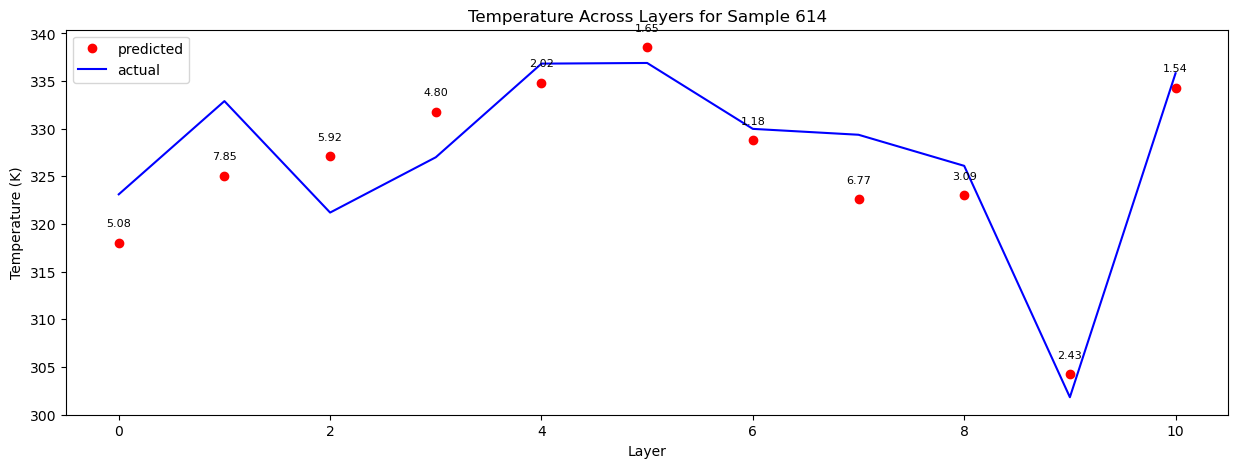

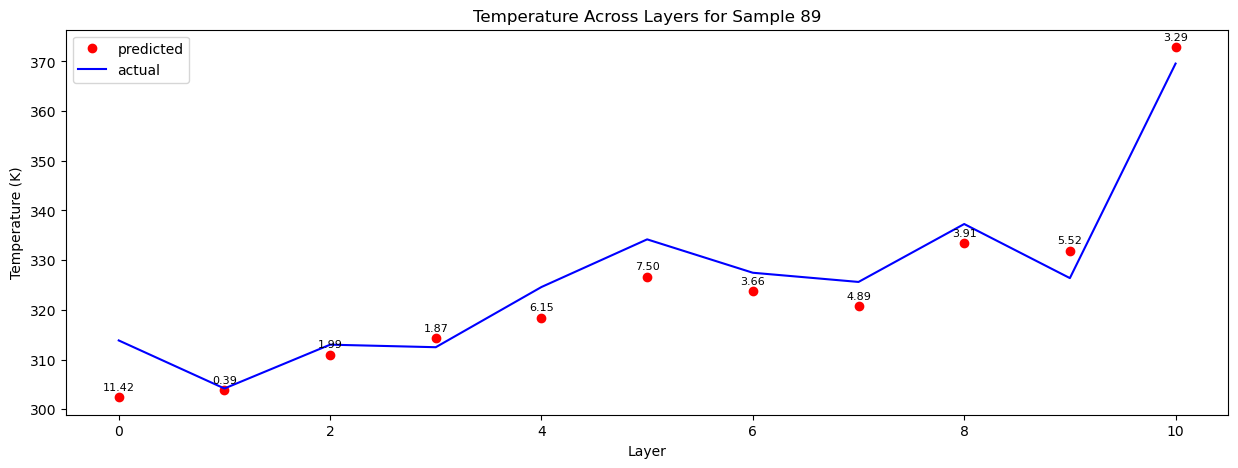

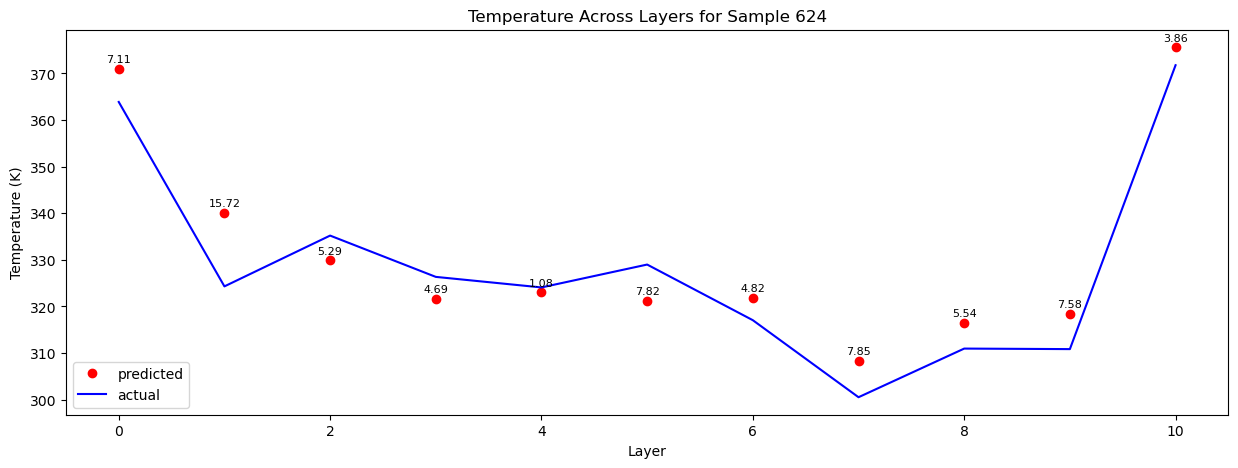

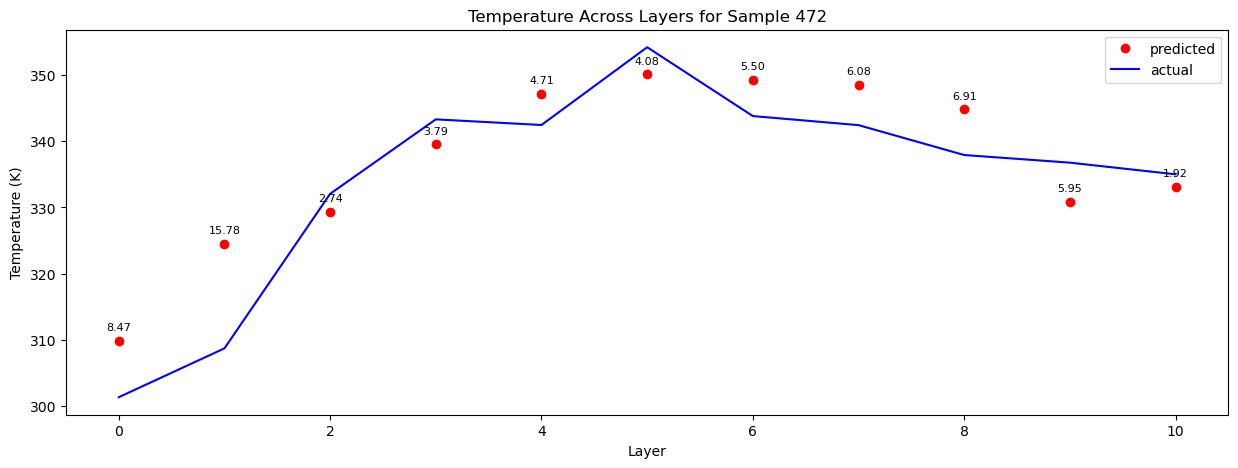

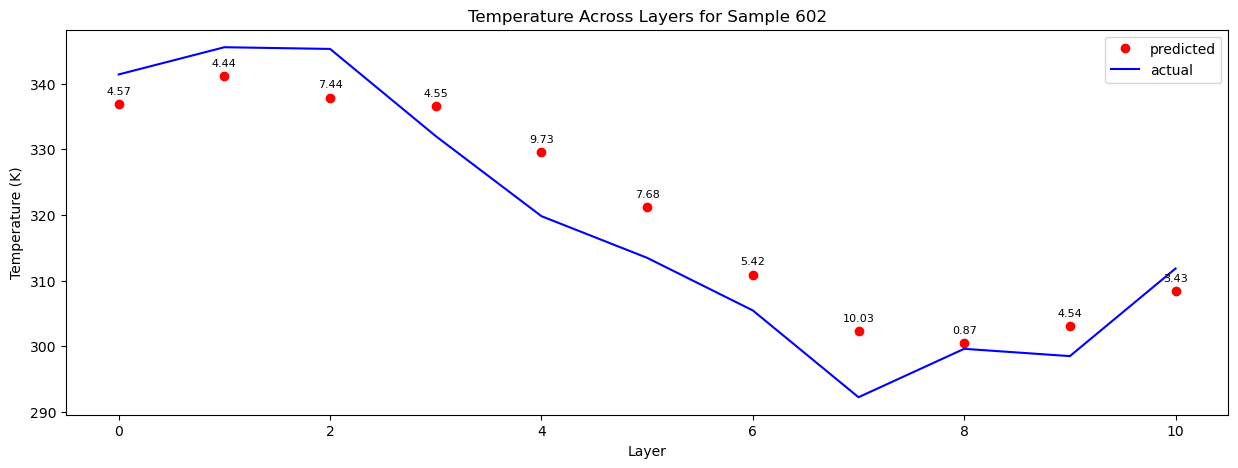

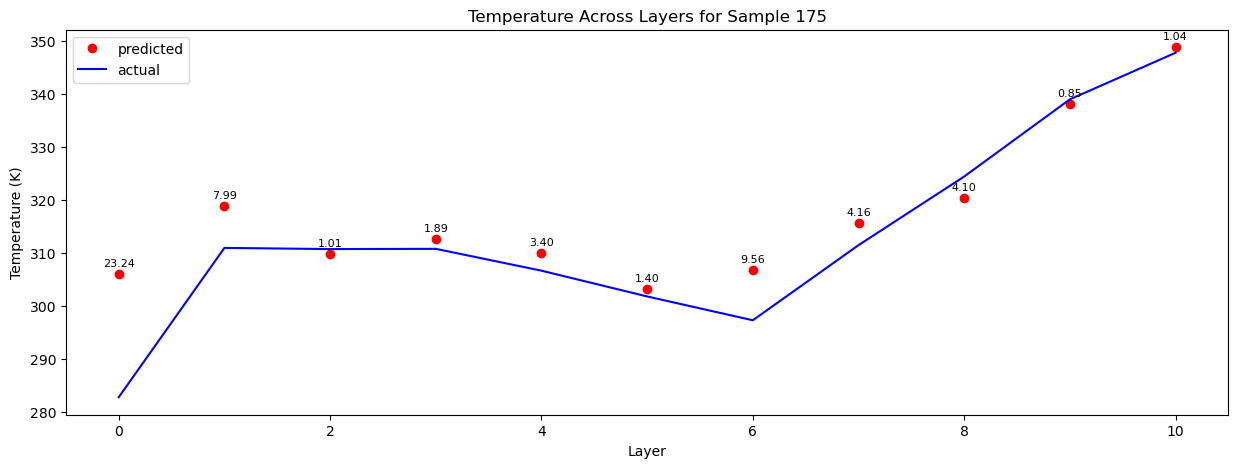

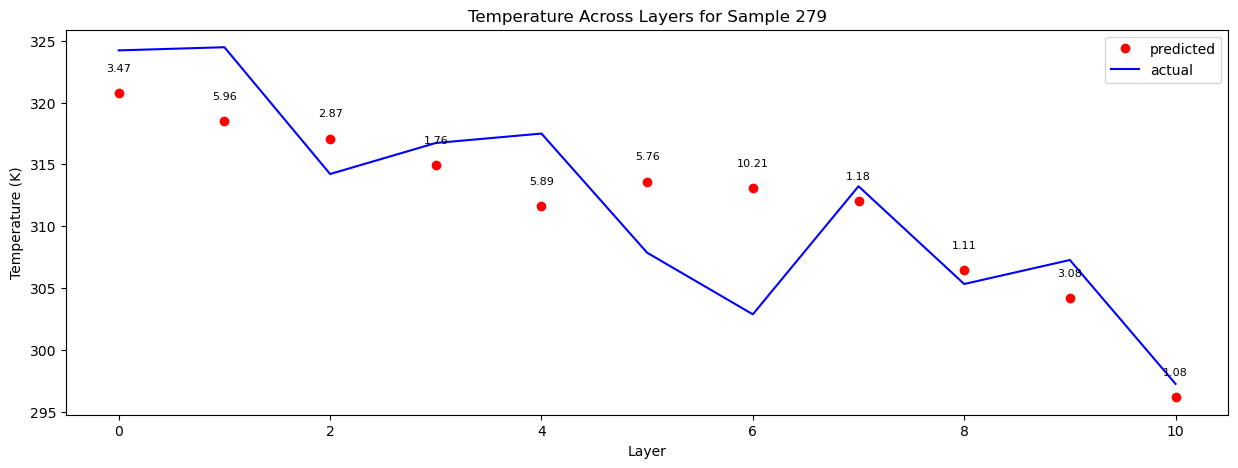

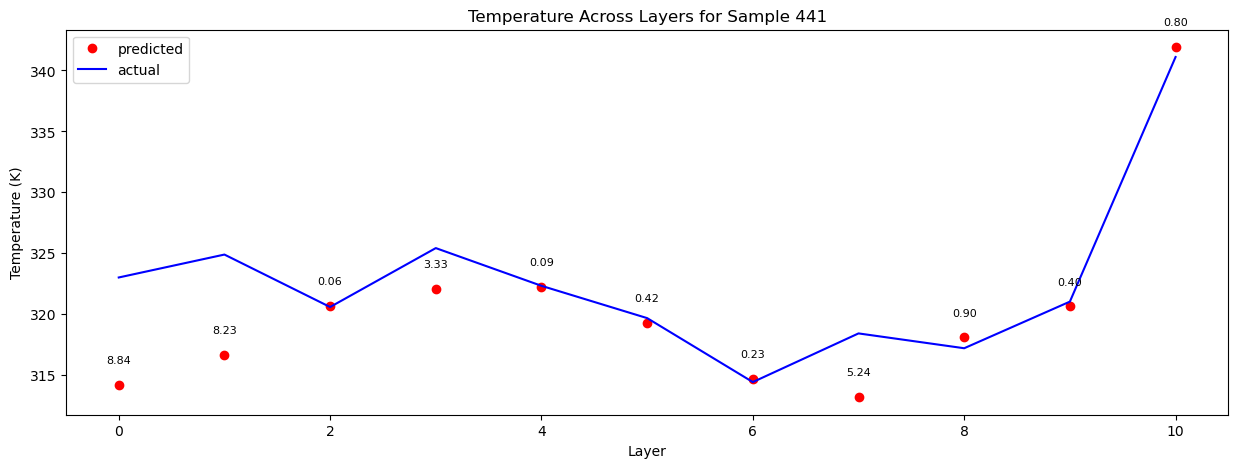

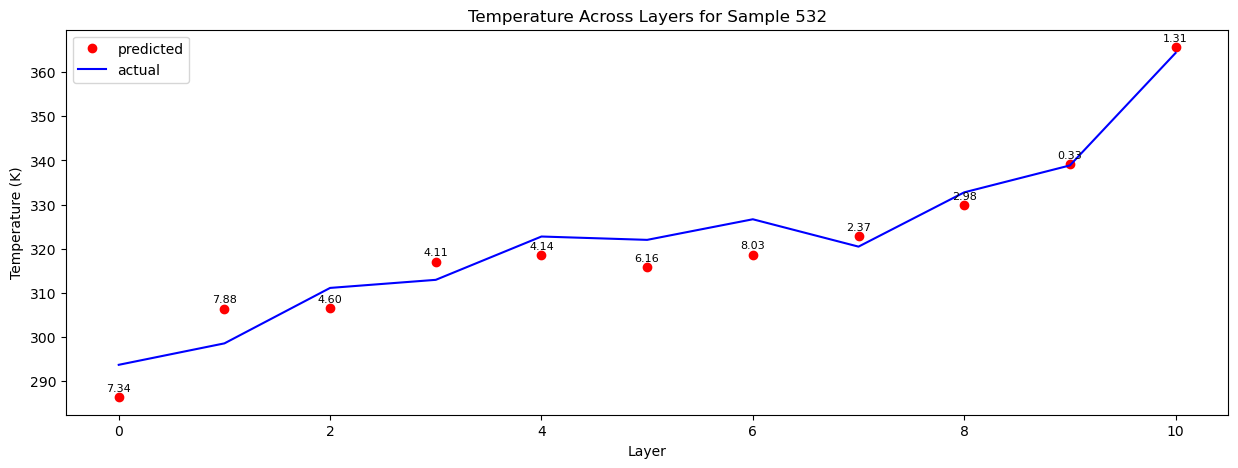

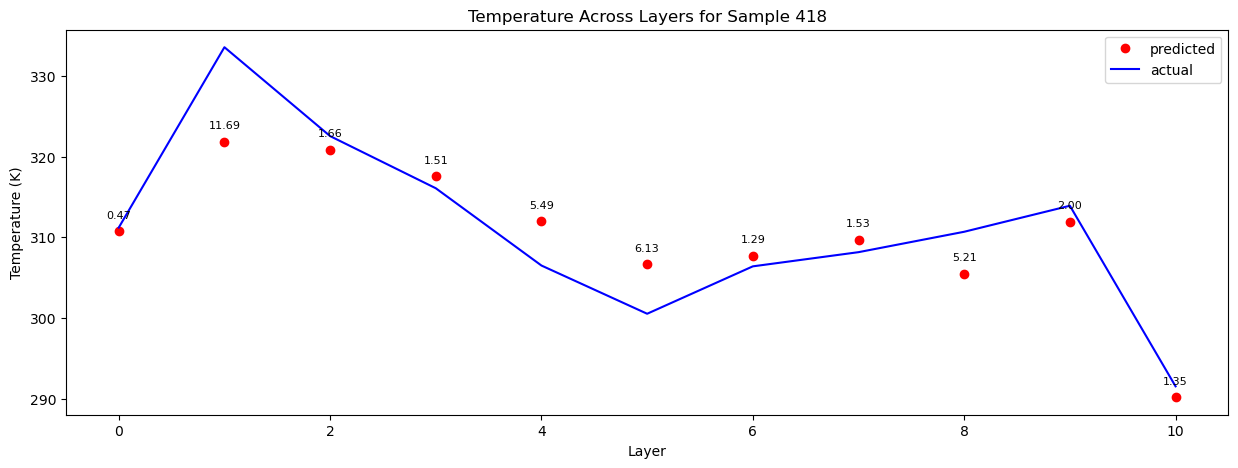

In [105]:
# find test losses and call plotting function
import random
num_graphs = 10
indices = []

test_losses = [0] * 11


with torch.no_grad():
    for i in range(len(all_pred_temp)):
        # sum loss for each entry
        for layer in range(len(all_pred_temp[0])):
            # print(f'layer {layer + 1} pred_temp: {pred_temp[layer]}, layer {layer + 1} temp_test: {temp_test[layer]}')
            l1_loss = abs(all_pred_temp[i][layer] - all_temp_test[i][layer]).item()
            test_losses[layer] += l1_loss

    # divide each loss by number of entries to find average loss per layer
    for i in range(len(test_losses)):
        test_losses[i] = test_losses[i] / len(all_pred_temp)

    print(f'test_losses: {test_losses}')


    # pick random indices to plot
    for i in range(0, num_graphs):
        n = random.randint(0, len(all_pred_temp))
        indices.append(n)

    # plot data for random set of entries
    for index in indices:
        plot_test_results(all_pred_temp[index], all_temp_test[index], index)


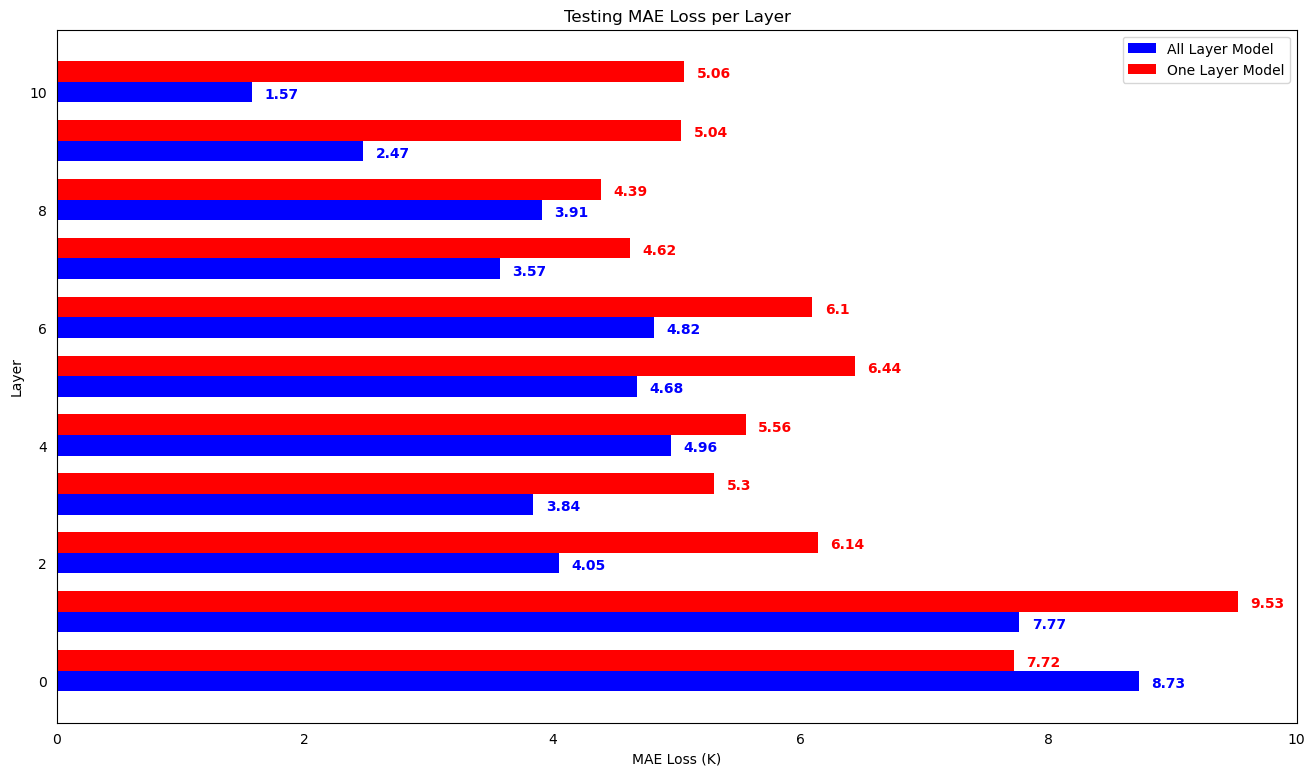

In [133]:
# All layer model test losses
# Plotting the test losses per layer

# create list of layer names
layer_names = []
for i in range(1, 12):
    layer_names.append(f'Layer {i}')
    
# Define the width of each bar
bar_width = 0.35

fig, ax = plt.subplots(figsize =(16, 9))
all_layer_bar = ax.barh(np.arange(len(layer_names)), test_losses, height=bar_width, color='blue', label='All Layer Model')
one_layer_bar = ax.barh(np.arange(len(layer_names)) + bar_width, one_test_losses, height=bar_width, color='red', label='One Layer Model')
 
# Remove axes splines
for s in ['bottom', 'left']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')


# Add annotation to bars
for i, bar in enumerate(all_layer_bar):
    plt.text(bar.get_width()+0.1, bar.get_y()+0.07,
             str(round((bar.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='blue')
    
for i, bar in enumerate(one_layer_bar):
    plt.text(bar.get_width()+0.1, bar.get_y()+0.07,
             str(round((bar.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='red')

plt.title("Testing MAE Loss per Layer")
plt.xlabel("MAE Loss (K)")
plt.ylabel("Layer")
plt.legend()

plt.show()

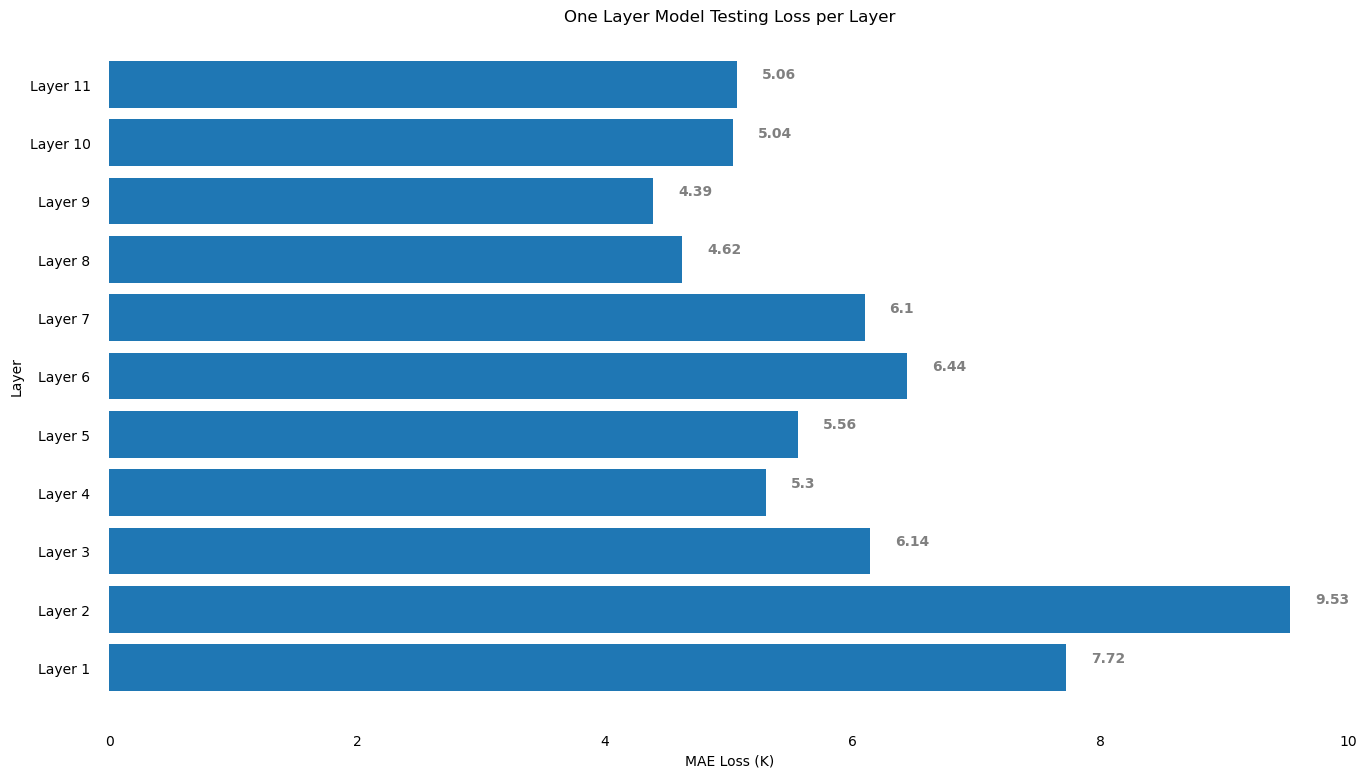

In [107]:
# One layer models test losses
# Plotting the test losses per layer

# create list of layer names
layer_names = []
for i in range(1, 12):
    layer_names.append(f'Layer {i}')

fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(layer_names, one_test_losses)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

plt.title("One Layer Model Testing Loss per Layer")
plt.xlabel("MAE Loss (K)")
plt.ylabel("Layer")

plt.show()